# Challenge Data QRT Stock Return Prediction 2020

This notebook illustrates my attempt on the 2020 Data Challenge that tries to predict the return of a stock in the US market using historical data over a recent period of 20 days.

## Used libraries

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,KFold

## Loading data

The train and test inputs are composed of 46 features.

The target of this challenge is to predict the column `RET` that corresponds to the fact that the **return is in the top 50% of highest stock returns** : if it is the case, RET = True, else False. This problem can be represented by a classification problem where the first class will be 1 if RET = True and the second class 0 if RET = False.

Since the median is very close to 0, this information should not change much with the idea to predict the sign of the return.

In [4]:
x_train_csv = str(sys.path[0])+'\\x_train.csv'
y_train_csv = str(sys.path[0])+'\\y_train.csv'

x_train = pd.read_csv(x_train_csv, index_col='ID')
y_train = pd.read_csv(y_train_csv, index_col='ID')
train = pd.concat([x_train, y_train], axis=1)
test = pd.read_csv('x_test.csv', index_col='ID')
train

,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,...,VOLUME_16,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20,RET
ID,,,,,,,,,,,,,,,,,,,,,
0,0,2,18,5,3,44,-0.015748,0.147931,-0.015504,0.179183,...,0.630899,0.003254,-0.379412,0.008752,-0.110597,-0.012959,0.174521,-0.002155,-0.000937,True
1,0,3,43,15,6,104,0.003984,NaN,-0.090580,NaN,...,NaN,0.003774,NaN,-0.018518,NaN,-0.028777,NaN,-0.034722,NaN,True
2,0,4,57,20,8,142,0.000440,-0.096282,-0.058896,0.084771,...,-0.010336,-0.017612,-0.354333,-0.006562,-0.519391,-0.012101,-0.356157,-0.006867,-0.308868,False
3,0,8,1,1,1,2,0.031298,-0.429540,0.007756,-0.089919,...,0.012105,0.033824,-0.290178,-0.001468,-0.663834,-0.013520,-0.562126,-0.036745,-0.631458,False
4,0,14,36,12,5,92,0.027273,-0.847155,-0.039302,-0.943033,...,-0.277083,-0.012659,0.139086,0.004237,-0.017547,0.004256,0.579510,-0.040817,0.802806,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418590,223,5703,32,10,4,77,0.021843,-0.217823,-0.021703,-0.125333,...,-0.161543,0.007785,-0.141487,0.008205,-0.268215,-0.058448,0.057577,0.031174,-0.163350,False
418591,223,5705,35,12,5,91,-0.006920,-0.375251,0.000000,-0.029437,...,-0.955492,-0.016221,-0.171172,0.007819,1.540184,-0.015396,-0.502337,-0.011073,0.632885,False
418592,223,5709,2,1,1,5,0.021869,-0.978856,-0.005929,-1.026267,...,-0.476550,0.029714,-0.385972,-0.069148,1.780169,-0.082927,1.581453,0.098607,6.956960,True


## Feature Engineering

The main principal problem in this challenge would be to deal with the noise. To do that, we could create some feature that aggregate features with some statistics.

The next cell computes statistics on a given target conditionally to some features. For example, we will try to generate a feature that describe the mean, min, max and standard deviation of `RET_1` conditionally to the `SECTOR` and the `DATE`.

In [5]:
# Feature engineering
new_features = []

# Conditional aggregated features
shifts = [1]  # We could choose some different shifts
statistics = ['mean','min','max','std']  # The type of statistic
gb_features = ['SECTOR', 'DATE']
target_feature = 'RET'
tmp_name = '_'.join(gb_features)
# The shift represents the number of days before the day we consider.
for shift in shifts:
    for stat in statistics:
        name = f'{target_feature}_{shift}_{tmp_name}_{stat}'
        feat = f'{target_feature}_{shift}'
        new_features.append(name)
        for data in [train, test]:
            data[name] = data.groupby(gb_features)[feat].transform(stat) # To apply the transformation stat
            # on the conditional data (as it was grouped by the parameters that we want to condition with respect to)

## Feature selection

To reduce the number of feature (and the noise) we are only going to consider the 5 last days of `RET` and `VOLUME` in addition to the newly created feature.

In [6]:
target = 'RET' # Here we define the final metric that is considered for the classification, so the output.

n_shifts = 5  # If we don't want all the shifts to reduce noise
features = ['RET_%d' % (i + 1) for i in range(n_shifts)] # features = ['RET_1', 'RET_2', 'RET_3', 'RET_4', 'RET_5']
features += ['VOLUME_%d' % (i + 1) for i in range(n_shifts)] # features = ['RET_1', 'RET_2', 'RET_3', 'RET_4', 'RET_5', 'VOLUME_1', 'VOLUME_2', 'VOLUME_3', 'VOLUME_4', 'VOLUME_5']
features += new_features  # The conditional features created before are all stored in this list with the RET_ and VOLUME_ ones.
train[features].head()

,RET_1,RET_2,RET_3,RET_4,RET_5,VOLUME_1,VOLUME_2,VOLUME_3,VOLUME_4,VOLUME_5,RET_1_SECTOR_DATE_mean,RET_1_SECTOR_DATE_min,RET_1_SECTOR_DATE_max,RET_1_SECTOR_DATE_std
ID,,,,,,,,,,,,,,
0,-0.015748,-0.015504,0.010972,-0.014672,0.016483,0.147931,0.179183,0.033832,-0.362868,-0.972920,0.009178,-0.105345,0.134000,0.024243
1,0.003984,-0.090580,0.018826,-0.025540,-0.038062,NaN,NaN,NaN,NaN,NaN,0.006477,-0.119048,0.314424,0.034339
2,0.000440,-0.058896,-0.009042,0.024852,0.009354,-0.096282,0.084771,-0.298777,-0.157421,0.091455,0.013449,-0.159287,0.242685,0.038375
3,0.031298,0.007756,-0.004632,-0.019677,0.003544,-0.429540,-0.089919,-0.639737,-0.940163,-0.882464,0.017253,-0.034853,0.082619,0.022464
4,0.027273,-0.039302,0.000000,0.000000,0.022321,-0.847155,-0.943033,-1.180629,-1.313896,-1.204398,0.006241,-0.134857,0.074074,0.022162


## Model and local score

The model we choose for this test is a Random Forest (RF) model. We will consider a large number of tree with a quiet small depth to reduce the possibility of overfitting. Those parameters can be changed in the future and optimized. The missing values will simply be filled with 0 for the moment. A KFold is done on the dates (using `DATE`) for a local scoring of the model.

In [7]:
X_train = train[features]
y_train = train[target]

# A quiet large number of trees with low depth is needed to prevent overfits
# We now define the parameters of the Random Forest
rf_params = {
    'n_estimators': 500,
    'max_depth': 2**3,
    'random_state': 0,
    'n_jobs': -1
}

# We store the unique dates in the train and in the test data.
train_dates = train['DATE'].unique()
test_dates = test['DATE'].unique()

n_splits = 4
scores = []
models = []

# Let's define the splits with the Kfold, the data will be split into four parts, and each
# will be used as the test set once while the other three are used for training.
splits = KFold(n_splits=n_splits, random_state=0,
               shuffle=True).split(train_dates)

for i, (local_train_dates_ids, local_test_dates_ids) in enumerate(splits):
    # Here we basically use the same principle as the train_test_split function but we do it n_splits times.
    local_train_dates = train_dates[local_train_dates_ids]
    local_test_dates = train_dates[local_test_dates_ids]

    local_train_ids = train['DATE'].isin(local_train_dates)
    local_test_ids = train['DATE'].isin(local_test_dates)

    X_local_train = X_train.loc[local_train_ids]
    y_local_train = y_train.loc[local_train_ids]
    X_local_test = X_train.loc[local_test_ids]
    y_local_test = y_train.loc[local_test_ids]

    # We fill the NaN values with 0.
    X_local_train = X_local_train.fillna(0)
    X_local_test = X_local_test.fillna(0)

    # Debugging NaN checks in case the file is not fully loaded for example (as working on Google Colab)
    assert not X_local_train.isnull().values.any(), "X_local_train contains NaN values"
    assert not X_local_test.isnull().values.any(), "X_local_test contains NaN values"
    assert not y_local_train.isnull().values.any(), "y_local_train contains NaN values"
    assert not y_local_test.isnull().values.any(), "y_local_test contains NaN values"

    # Let's now fit the Random Forest model with the parameters defined above.
    model = RandomForestClassifier(**rf_params)
    model.fit(X_local_train, y_local_train)

    # We apply the model trained on the X_local_train data to the X_local_test data
    y_local_pred = model.predict_proba(X_local_test)[:, 1]

    # We create a copy of the train dataframe
    sub = train.loc[local_test_ids].copy()
    # We add the output of the trained model on the X_local_test data
    sub['pred'] = y_local_pred

    # We want the prediction to be True if the value is superior to the value of the median as it would mean that
    # the return is in the top 50% of highest stock returns.
    y_local_pred = sub.groupby('DATE')['pred'].transform(lambda x: x > x.median()).values

    models.append(model)
    score = accuracy_score(y_local_test, y_local_pred)
    scores.append(score)
    # We display the accuracy for each fold
    print(f"Fold {i+1} - Accuracy: {score* 100:.2f}%")

# Finally, we will print the mean result of the n_splits folds, with its standard deviation defining a confidence interval
mean = np.mean(scores)*100
std = np.std(scores)*100
u = (mean + std)
l = (mean - std)
print(f'Accuracy: {mean:.2f}% [{l:.2f} ; {u:.2f}] (+- {std:.2f})')

Fold 1 - Accuracy: 51.95%
Fold 2 - Accuracy: 50.38%
Fold 3 - Accuracy: 51.09%
Fold 4 - Accuracy: 51.70%
Accuracy: 51.28% [50.68 ; 51.89] (+- 0.61)


In [8]:
# We can visualize which feature is the most important in the model we just built.
# We can expect it to be the conditional features we created.
feature_importances = pd.DataFrame([model.feature_importances_ for model in models], columns=features)

sns.barplot(data=feature_importances, orient='h', order=feature_importances.mean().sort_values(ascending=False).index)

AttributeError: 'DataFrame' object has no attribute 'iteritems'

# Feature Engineering Bis

Now, we are going to try to improve the previous feature engineering made on the data. As ideas of improvement, we could try to change shifts by adding more values and calculate statistics on a given target, here Return, conditionaly to some new features. For the record, we already calculated multiple statistics. The next variation of the method could be to change the target variable as the primary focus was on the Return as it is the variable we would like to predict, but it can also be done on the volumes.

In [9]:
x_train = pd.read_csv('x_train.csv', index_col='ID')
y_train = pd.read_csv('y_train.csv', index_col='ID')
train = pd.concat([x_train, y_train], axis=1)
test = pd.read_csv('x_test.csv', index_col='ID')

We handle the missing values differently than previously where we just decided to fill them with NaN values :
- For VOLUME: We replace missing values with the average volume of the same sector for the same date. If this condition can't be met, for example if no data is available for that particular date, we average the sector for all dates. Finally, if this fallback doesn't work, we can use the global mean of the columns, so for all stocks.
- For RET: We replace missing values using the average of the values in the same row’s immediate left (RET_shift-1) and right (RET_shift+1) columns, so the day before and the day after. If this condition can't be met, so if the considered column is the first or the last of the RET_ columns of the dataframe, we fallback to the previous or the next column, depending on the one available. If one of them has also NaN values, we use the mean return for the same sector and date. And finally, we fallback to the global mean of the returns for the column.

This could also be done by creating some fallback strategies based on the industry_group or the industry instead of the sector.

In [10]:
def handle_missing_values(data):
    # We fill missing volumes with the sector's mean volume for the same date
    for col in [col for col in data.columns if 'VOLUME' in col]:
        # First, we try by filling with sector and date means
        data[col] = data.groupby(['SECTOR', 'DATE'])[col].transform(
            lambda x: x.fillna(x.mean())
        )
        # First fallback: we use the overall sector mean if date-level mean is NaN
        data[col] = data.groupby('SECTOR')[col].transform(
            lambda x: x.fillna(x.mean())
        )
        # Final fallback: we use the global mean for the column
        data[col] = data[col].fillna(data[col].mean())

    # Then, we fill missing returns with the average of adjacent columns
    ret_columns = [col for col in data.columns if col.startswith('RET_')]
    for col in ret_columns:
        col_idx = int(col.split('_')[1])  # We extract the numeric suffix to consider the two (or only one) adjacents columns
        prev_col = f'RET_{col_idx - 1}' if col_idx > 1 else None
        next_col = f'RET_{col_idx + 1}' if f'RET_{col_idx + 1}' in ret_columns else None

        if prev_col and next_col:
            # We average both adjacent columns to get the filling value
            data[col] = data[col].fillna(
                (data[prev_col] + data[next_col]) / 2
            )
        if prev_col:
            # We fallback to the previous column if it is available
            data[col] = data[col].fillna(data[prev_col])
        if next_col:
            # We fallback to the next column if it is available
            data[col] = data[col].fillna(data[next_col])

        # Additional fallback: we use the mean return for the same sector and date
        data[col] = data.groupby(['SECTOR', 'DATE'])[col].transform(
            lambda x: x.fillna(x.mean())
        )

        # Final fallback: we use the global mean return for the column if none of the previous fallback worked
        data[col] = data[col].fillna(data[col].mean())

    return data

# Let's preprocess train and test datasets to clean all missing values by filling them with the rules defined above
train = handle_missing_values(train)
test = handle_missing_values(test)

In [11]:
# We check that no columns have missing data.
train.isnull().sum()

DATE              0
STOCK             0
INDUSTRY          0
INDUSTRY_GROUP    0
SECTOR            0
SUB_INDUSTRY      0
RET_1             0
VOLUME_1          0
RET_2             0
VOLUME_2          0
RET_3             0
VOLUME_3          0
RET_4             0
VOLUME_4          0
RET_5             0
VOLUME_5          0
RET_6             0
VOLUME_6          0
RET_7             0
VOLUME_7          0
RET_8             0
VOLUME_8          0
RET_9             0
VOLUME_9          0
RET_10            0
VOLUME_10         0
RET_11            0
VOLUME_11         0
RET_12            0
VOLUME_12         0
RET_13            0
VOLUME_13         0
RET_14            0
VOLUME_14         0
RET_15            0
VOLUME_15         0
RET_16            0
VOLUME_16         0
RET_17            0
VOLUME_17         0
RET_18            0
VOLUME_18         0
RET_19            0
VOLUME_19         0
RET_20            0
VOLUME_20         0
RET               0
dtype: int64

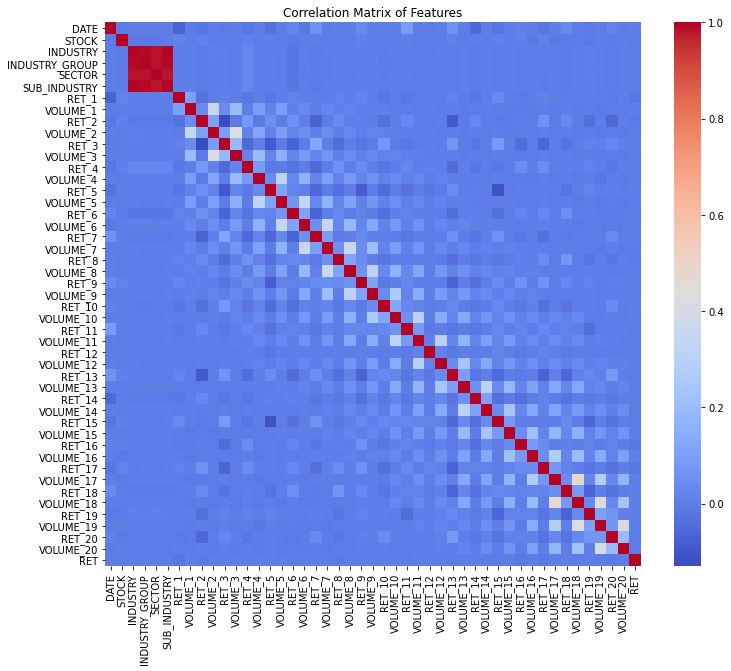

In [12]:
# We could also print the matrix of correlation of the different features in order to understand what
# conditionality we should consider between the features and the target variable.
# The mean correlations are of course between Industry, Industry_group, Secotr and Sub_Industry and between volumes from days to days.
correlation_matrix = train.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

In [13]:
correlation_matrix

,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,...,VOLUME_16,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20,RET
DATE,1.000000,-0.007430,-0.000682,-0.000720,-0.000714,-0.000639,-0.071861,-0.002043,-0.014812,-0.001359,...,0.000821,-0.022053,0.003439,0.038149,-0.001369,-0.006160,0.000181,0.014630,-0.003022,0.000473
STOCK,-0.007430,1.000000,-0.005968,-0.007242,-0.007360,-0.003550,0.012167,-0.001812,0.010294,-0.001533,...,-0.007950,0.015000,-0.008535,-0.005169,-0.001661,-0.008116,-0.000406,-0.008244,-0.000015,-0.002843
INDUSTRY,-0.000682,-0.005968,1.000000,0.994895,0.982486,0.997780,0.001818,0.005092,-0.006818,0.007507,...,0.004165,-0.001704,0.003219,-0.007291,0.002808,0.007436,0.002773,-0.004050,0.000741,-0.000997
INDUSTRY_GROUP,-0.000720,-0.007242,0.994895,1.000000,0.983174,0.994487,0.002675,0.004850,-0.007276,0.007114,...,0.004182,-0.001078,0.002762,-0.006549,0.002497,0.006815,0.002249,-0.003709,0.000720,-0.000737
SECTOR,-0.000714,-0.007360,0.982486,0.983174,1.000000,0.980162,0.002268,0.004396,-0.006845,0.006581,...,0.004153,-0.002495,0.002888,-0.006047,0.001976,0.008337,0.001433,-0.004185,0.000337,-0.000137
SUB_INDUSTRY,-0.000639,-0.003550,0.997780,0.994487,0.980162,1.000000,0.002343,0.004867,-0.006798,0.007151,...,0.004152,-0.001413,0.002935,-0.007511,0.002884,0.007095,0.002844,-0.003883,0.000634,-0.001140
RET_1,-0.071861,0.012167,0.001818,0.002675,0.002268,0.002343,1.000000,0.102544,-0.031646,0.002632,...,0.003142,0.012867,0.002335,-0.001625,0.000933,0.005941,0.001291,-0.008906,0.004223,-0.016771
VOLUME_1,-0.002043,-0.001812,0.005092,0.004850,0.004396,0.004867,0.102544,1.000000,0.042108,0.348768,...,-0.006409,0.001204,-0.006160,0.001017,-0.007795,0.000430,-0.007564,-0.002793,-0.005172,0.004570
RET_2,-0.014812,0.010294,-0.006818,-0.007276,-0.006845,-0.006798,-0.031646,0.042108,1.000000,0.102553,...,-0.003777,0.063303,-0.006418,0.034749,-0.003064,-0.040695,0.000827,-0.055703,0.003039,-0.009040
VOLUME_2,-0.001359,-0.001533,0.007507,0.007114,0.006581,0.007151,0.002632,0.348768,0.102553,1.000000,...,-0.005513,-0.000525,-0.005333,-0.000713,-0.007868,0.001174,-0.009717,-0.000880,-0.007467,0.001029


We will here try to generate a feature that describe the mean, min, max and standard deviation of `RET_1` to `RET_5` conditionally to the `SECTOR` and the `DATE`, the `INDUSTRY_GROUP` and the `DATE` and the `INDUSTRY` and the `DATE` to create more conditional features and hopefully improve the accuracy of our model.

In [14]:
# Feature engineering
new_features = []

# Conditional aggregated features : we added the Industry_group
shifts = [1, 2, 3, 4, 5]
statistics = ['mean','min','max','std']  # The type of statistic
gb_features = [['SECTOR', 'DATE'], ['INDUSTRY_GROUP', 'DATE'], ['INDUSTRY', 'DATE']]
target_feature = ['RET', 'VOLUME']
# The shift represents the number of days before the day we consider.
for target in target_feature:
  for gb_feature in gb_features:
    for shift in shifts:
        for stat in statistics:
            tmp_name = '_'.join(gb_feature)
            name = f'{target}_{shift}_{tmp_name}_{stat}'
            feat = f'{target}_{shift}'
            new_features.append(name)
            for data in [train, test]:
                data[name] = data.groupby(gb_feature)[feat].transform(stat)
                data[name] = data[name].fillna(method='bfill').fillna(method='ffill')
                # Here we fill some missing values of the standard deviation that could create some NaN values in the data.

<ipython-input-14-3b3467580c96>:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[name] = data.groupby(gb_feature)[feat].transform(stat)
<ipython-input-14-3b3467580c96>:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[name] = data.groupby(gb_feature)[feat].transform(stat)
<ipython-input-14-3b3467580c96>:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instea

# Feature Selection Bis

In [15]:
target = 'RET'

n_shifts = 5
features = ['RET_%d' % (i + 1) for i in range(n_shifts)] # features = ['RET_1', 'RET_2', 'RET_3', 'RET_4', 'RET_5']
features += ['VOLUME_%d' % (i + 1) for i in range(n_shifts)] # features = ['RET_1', 'RET_2', 'RET_3', 'RET_4', 'RET_5', 'VOLUME_1', 'VOLUME_2', 'VOLUME_3', 'VOLUME_4', 'VOLUME_5']
features += new_features
train[features].head()

,RET_1,RET_2,RET_3,RET_4,RET_5,VOLUME_1,VOLUME_2,VOLUME_3,VOLUME_4,VOLUME_5,...,VOLUME_3_INDUSTRY_DATE_max,VOLUME_3_INDUSTRY_DATE_std,VOLUME_4_INDUSTRY_DATE_mean,VOLUME_4_INDUSTRY_DATE_min,VOLUME_4_INDUSTRY_DATE_max,VOLUME_4_INDUSTRY_DATE_std,VOLUME_5_INDUSTRY_DATE_mean,VOLUME_5_INDUSTRY_DATE_min,VOLUME_5_INDUSTRY_DATE_max,VOLUME_5_INDUSTRY_DATE_std
ID,,,,,,,,,,,,,,,,,,,,,
0,-0.015748,-0.015504,0.010972,-0.014672,0.016483,0.147931,0.179183,0.033832,-0.362868,-0.972920,...,1.426388,0.743043,-0.215966,-0.746342,0.597689,0.431639,-0.455239,-0.972920,-0.065641,0.314736
1,0.003984,-0.090580,0.018826,-0.025540,-0.038062,0.009725,-0.039260,-0.189169,-0.262853,-0.209702,...,0.927769,0.398013,-0.302671,-1.280212,8.755558,1.190099,-0.188548,-1.190652,8.413029,1.252840
2,0.000440,-0.058896,-0.009042,0.024852,0.009354,-0.096282,0.084771,-0.298777,-0.157421,0.091455,...,5.539782,0.950714,-0.152875,-1.166698,6.917564,1.043218,-0.113151,-1.189309,8.762385,1.303000
3,0.031298,0.007756,-0.004632,-0.019677,0.003544,-0.429540,-0.089919,-0.639737,-0.940163,-0.882464,...,1.285789,0.495449,-0.214578,-0.967795,1.770693,0.548485,-0.557493,-1.111108,0.351711,0.341009
4,0.027273,-0.039302,0.000000,0.000000,0.022321,-0.847155,-0.943033,-1.180629,-1.313896,-1.204398,...,0.723614,0.421935,-0.189692,-1.313896,2.234868,0.714730,-0.220659,-1.404361,3.457331,0.858263


In [16]:
train[features].isnull().sum()

RET_1                          0
RET_2                          0
RET_3                          0
RET_4                          0
RET_5                          0
                              ..
VOLUME_4_INDUSTRY_DATE_std     0
VOLUME_5_INDUSTRY_DATE_mean    0
VOLUME_5_INDUSTRY_DATE_min     0
VOLUME_5_INDUSTRY_DATE_max     0
VOLUME_5_INDUSTRY_DATE_std     0
Length: 130, dtype: int64

## Model and local score Bis

We are going to tune the hyperparameters of the Random Forest in order to improve the accuracy of the model.

Other improvements such as changing the features considered and trying other models (such as Support Vector Models, eXtreme Gradient Boosting etc) could also be implemented as next steps.

In [ ]:
X_train = train[features]
y_train = train[target]

train_dates = train['DATE'].unique()
test_dates = test['DATE'].unique()

n_splits = 4
scores = []
models = []

# Define hyperparameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [4, 6, 8, 12],
    'random_state': [0],
    'n_jobs': [-1],
}

splits = KFold(n_splits=n_splits, random_state=0, shuffle=True).split(train_dates)

for i, (local_train_dates_ids, local_test_dates_ids) in enumerate(splits):
    local_train_dates = train_dates[local_train_dates_ids]
    local_test_dates = train_dates[local_test_dates_ids]

    local_train_ids = train['DATE'].isin(local_train_dates)
    local_test_ids = train['DATE'].isin(local_test_dates)

    X_local_train = X_train.loc[local_train_ids]
    y_local_train = y_train.loc[local_train_ids]
    X_local_test = X_train.loc[local_test_ids]
    y_local_test = y_train.loc[local_test_ids]

    # Debugging NaN checks
    assert not X_local_train.isnull().values.any(), "X_local_train contains NaN values"
    assert not X_local_test.isnull().values.any(), "X_local_test contains NaN values"
    assert not y_local_train.isnull().values.any(), "y_local_train contains NaN values"
    assert not y_local_test.isnull().values.any(), "y_local_test contains NaN values"

    # We implement some grid Search to find the best hyperparameters
    rf = RandomForestClassifier()
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1)
    grid_search.fit(X_local_train, y_local_train)

    # We train the Random Forest with best hyperparameters
    best_params = grid_search.best_params_
    model = RandomForestClassifier(**best_params)
    model.fit(X_local_train, y_local_train)

    y_local_pred = model.predict_proba(X_local_test)[:, 1]

    sub = train.loc[local_test_ids].copy()
    sub['pred'] = y_local_pred

    # We adjust predictions to top 50% of returns for each date
    y_local_pred = sub.groupby('DATE')['pred'].transform(lambda x: x > x.median()).values

    # We append the results of the model to display their mean and standard deviation once the loop on the Kfolds is over.
    models.append(model)
    score = accuracy_score(y_local_test, y_local_pred)
    scores.append(score)
    print(f"Fold {i+1} - Accuracy: {score* 100:.2f}%")

# Let's calculate the overall statistics to see if the model has improved.
mean = np.mean(scores) * 100
std = np.std(scores) * 100
u = (mean + std)
l = (mean - std)
print(f'Accuracy: {mean:.2f}% [{l:.2f} ; {u:.2f}] (+- {std:.2f})')


In [ ]:
# We can visualize which feature is the most important in the model we just built and see if the importance of features was changed with the previous and simpler model.
feature_importances = pd.DataFrame([model.feature_importances_ for model in models], columns=features)

sns.barplot(data=feature_importances, orient='h', order=feature_importances.mean().sort_values(ascending=False).index)